# Evaluating a CellPose2 model

In this notebook, we will take predictions from our model_training notebook to compare with the ground truth data to showcase how to evaluate how a cell segmenting model performs.

Our data is pictures of cells and masks. The masks each segment multiple cells of the images and give each cell its own color code

## Individually segmenting out the cells

This process follows the following method:
    &nbsp;&nbsp;&nbsp;&nbsp;get the pixel values that are in the predicted mask (0 is the background)
    &nbsp;&nbsp;&nbsp;&nbsp;for each pixel value
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;get its 4 corners
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;calculate its longest diagonal
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;use it to create a bounding box around the cell
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;store the coordinates of that bounding box
    &nbsp;&nbsp;&nbsp;&nbsp;apply all of the bounding boxes around the original image to see if it retrieves the nuclei

In [1]:
#All the code for getting the crop coordinates
import math
from itertools import combinations
import numpy as np

#Function to get the number of cells in an image
#Input: image
#Output: number of cells
#The number of cells is defined by the number of different pixel intensities, excluding the background
def count_cells(img):
    numbers_found = []
    for i in range(len(img)):
        #if in one line of pixels there are only zeros, then there are no cells in that line
        current_line = img[i]
        if not np.all((current_line == 0)):
            for j in range(len(current_line)):
                if current_line[j] != 0: numbers_found.append(current_line[j])
    return len(set(numbers_found))


#Function to get the 4 coordinates of cell
#Input: binary image where cell is singled out
#Output: list with top left coordinates, bottom left coordinates, top right coordinates, bottom right coordinates
def get_corners(binary):
    top_left_col, top_left_row = None, None
    bot_right_col, bot_right_row = None, None
    top_right_col, top_right_row = None, None
    bot_left_col, bot_left_row = None, None

    #Get the first True's row and column (top left)
    for i in range(len(binary)):
        if True in binary[i]:
            top_left_row = i
            for j in range(len(binary[i])):
                if binary[i][j]:
                    top_left_col = j
                    break
        if top_left_row is not None and top_left_col is not None: break

    #(bottom left)
    for i in range(len(binary)):
        if True in binary[i]:
            while i < 1080 and True in binary[i]: i+=1
            bot_left_row = i-1
            for j in range(len(binary[bot_left_row])):
                if binary[bot_left_row][j]:
                    bot_left_col = j
                    break
        if bot_left_row is not None: break

    #Get the last True's row and column (bottom right)
    for i in range(len(binary)):
        if True in binary[i]:
            bot_right_row = i
            for j in range(len(binary[i])):
                if binary[i][j]: bot_right_col = j

    #Start reading from the columns (top right)
    for i in range(len(binary)):
        if True in binary[i]:
            top_right_row = i
            for j in range(len(binary[i])):
                if binary[i][j]: top_right_col = j
        if top_right_row is not None and top_right_col is not None: break
    return [(top_left_col,top_left_row),(bot_left_col,bot_left_row),(top_right_col,top_right_row),(bot_right_col,bot_right_row)]


#Function to get the center of a cell
#Input: 4 corners of a cell
#Output: coordinates of center of cell

def get_center(corners):

    x_coors = [corners[i][0] for i in range(4)]
    y_coors = [corners[i][1] for i in range(4)]
    center_col = int(sum(x_coors)/len(y_coors))
    center_row = int(sum(y_coors)/len(y_coors))

    return center_col,center_row


#Function to get the longest diagonal
#Input: 4 coordinates of cell
#Output: longest line between two points
def get_longest_line(corners):
    point_combinations = sum([list(map(list, combinations(corners, i))) for i in range(len(corners) + 1)], [])
    point_combinations = [combi for combi in point_combinations if len(combi)==2]

    longest = 0
    test = []
    for combi in point_combinations:
        current_len = math.hypot(combi[0][0] - combi[1][0], combi[0][1] - combi[1][1])
        test.append(current_len)
        if current_len > longest: longest = current_len

    return int(longest)


#Function that takes a mask and returns a crop of every cell inside it
#Input: image of cells (mask)
#Output: list of images that are crops of the cells in the inputted image

def get_cell_crop_coordinates(original_cells_img):
    copy_cells_img = np.copy(original_cells_img)

    #get the number of nuclei
    num_cells = count_cells(copy_cells_img)

    crops = []
    crop_coordinates = []

    #loop through the number of nuclei
    for nuclei_num in range(1,num_cells+1):

        #get singled out cell image
        cell_img = np.copy(copy_cells_img)
        cell_img = cell_img == nuclei_num

        corners = get_corners(cell_img) #get the four corners of the nuclei

        center_col, center_row = get_center(corners) #get the center of the nuclei

        margin = 10
        crop_len = int(get_longest_line(corners)/2)+margin #get the longest diag and divide by 2 for square crop half length

        bottom_row = max(0,center_row-crop_len)
        top_row = min(copy_cells_img.shape[0]-1,center_row+crop_len)
        bottom_col = max(0,center_col-crop_len)
        top_col = min(copy_cells_img.shape[1]-1,center_col+crop_len)

        crop_coordinates.append([bottom_row,top_row,bottom_col,top_col]) #store the crop coordinates

        crops.append(cell_img[bottom_row:top_row,bottom_col:top_col]) #make the crop and store it in the list

    return crop_coordinates

#Function to get crops on image from list of coordinates
#Input: original image, list of coordinates to crop around(4)
#Output: crops of these coordinates
def get_img_crops(img,list_of_coordinates):
    crops = [ img[coord[0]:coord[1],coord[2]:coord[3]] for coord in list_of_coordinates]
    return crops

In [4]:
#Load the model and data
from cellpose import models, io, metrics
model = models.CellposeModel(gpu=True,
                             pretrained_model='C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model')
train_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training"
test_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_testing"

In [6]:



#I need to add comments to this
channels = [0,0] #first 0: grayscale; second 0: None
diam_labels = model.diam_labels.copy() #diameter of labels in training images
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]
predicted_test_masks = model.eval(test_data,
                                  channels=channels,
                                  diameter=diam_labels)[0]

#Checking the performance
ap = metrics.average_precision(test_labels, predicted_test_masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


>>> average precision at iou threshold 0.5 = 0.823


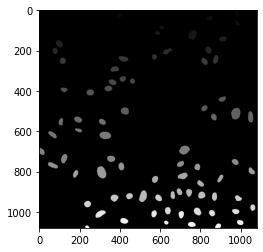

In [9]:
import matplotlib.pyplot as plt

plt.imshow(predicted_test_masks[0],cmap='gray')

In [11]:
cell_crop_coordinates_test = get_cell_crop_coordinates(predicted_test_masks[0])
crops_test = get_img_crops(predicted_test_masks[0],cell_crop_coordinates_test)

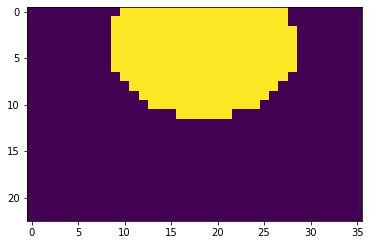

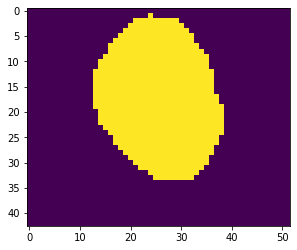

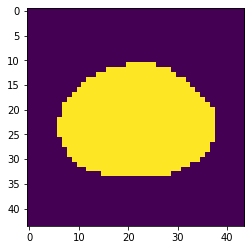

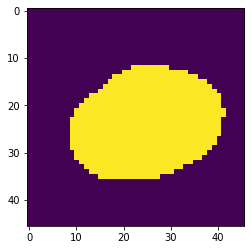

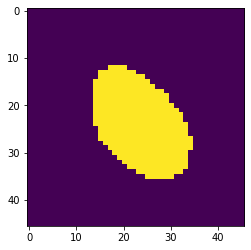

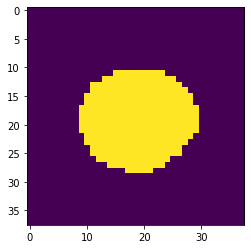

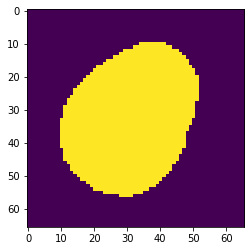

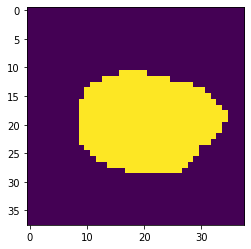

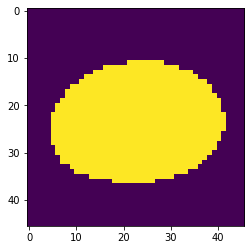

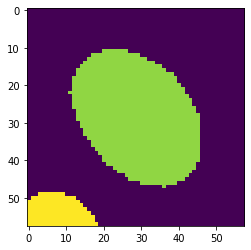

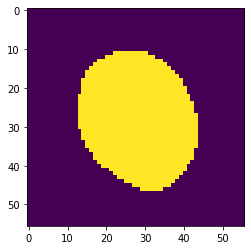

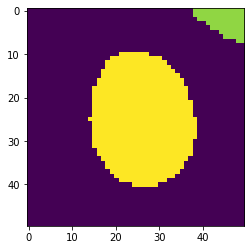

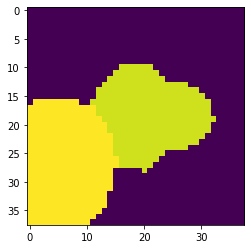

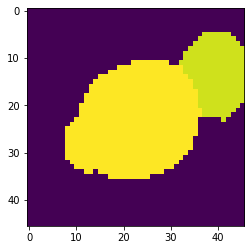

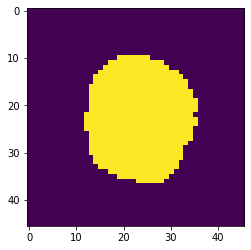

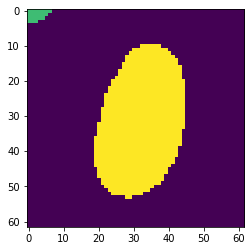

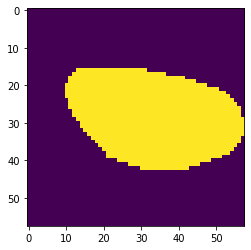

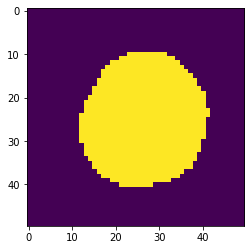

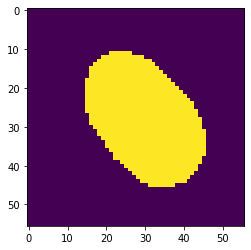

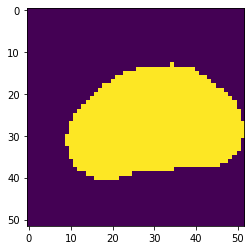

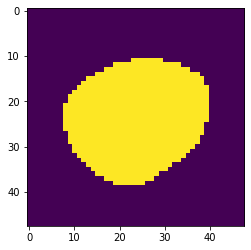

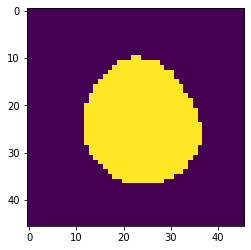

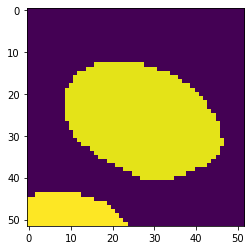

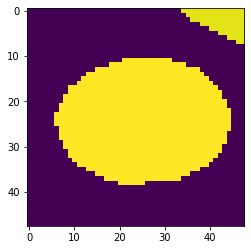

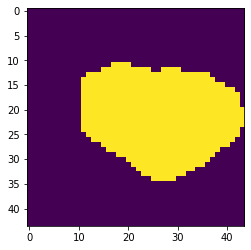

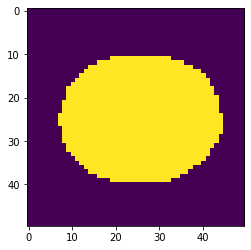

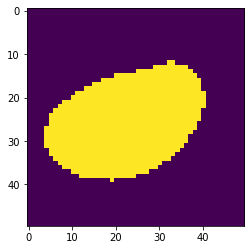

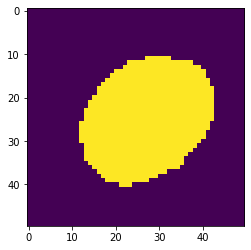

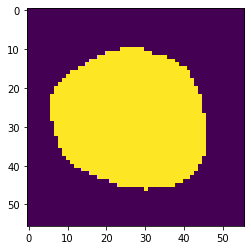

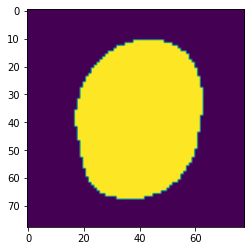

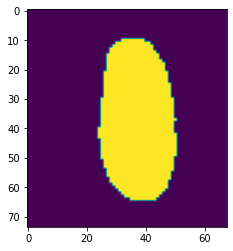

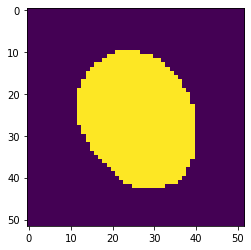

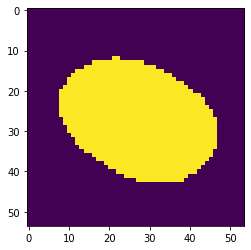

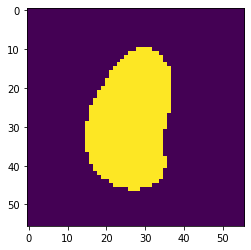

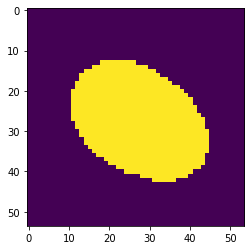

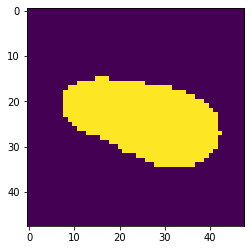

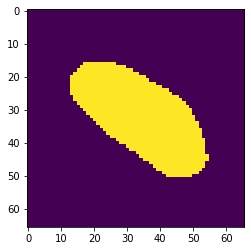

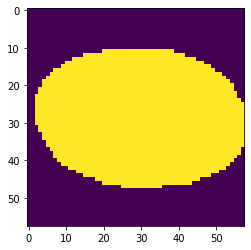

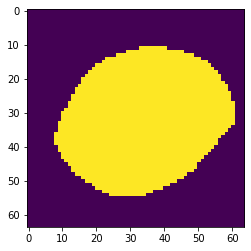

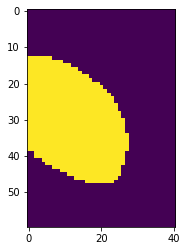

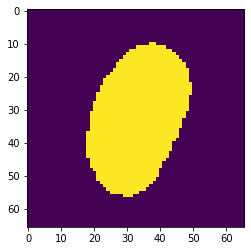

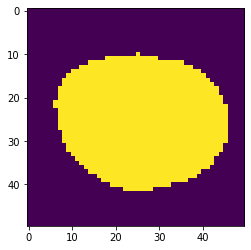

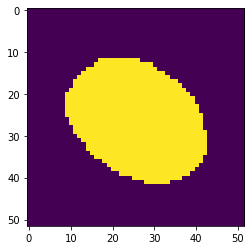

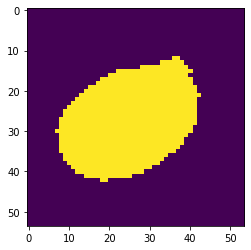

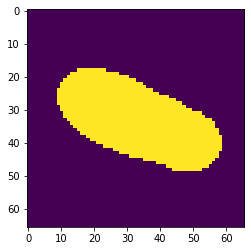

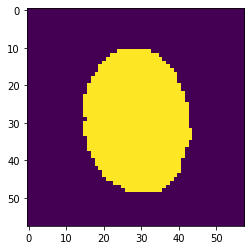

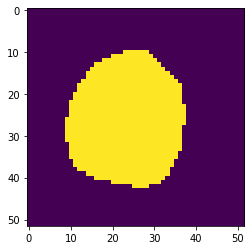

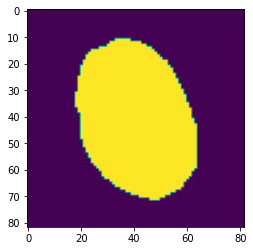

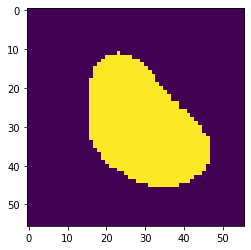

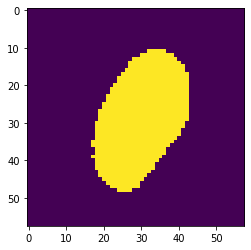

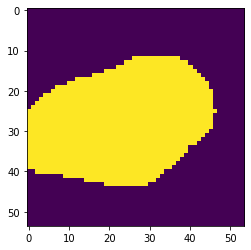

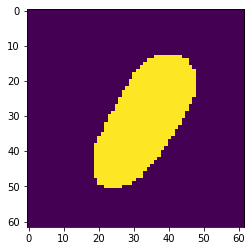

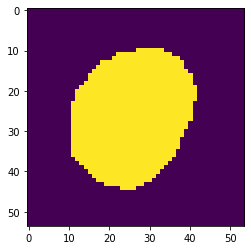

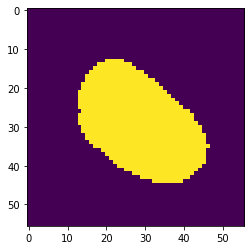

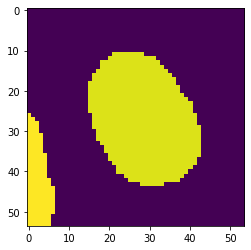

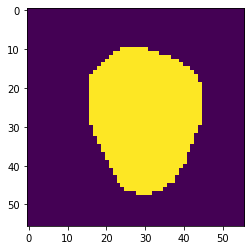

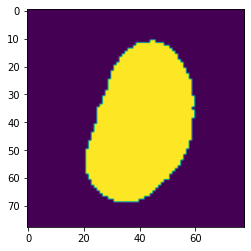

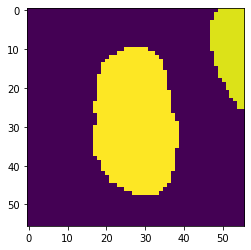

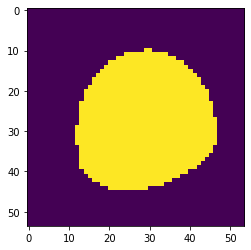

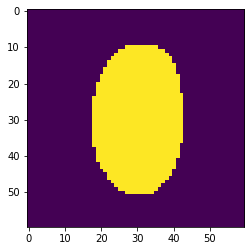

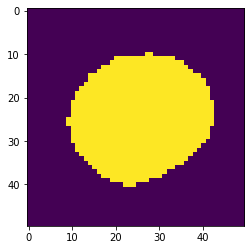

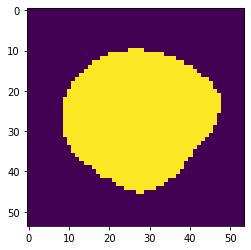

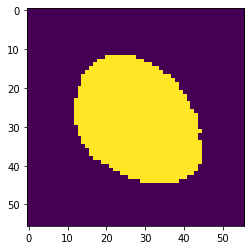

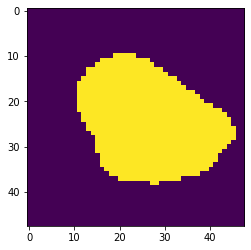

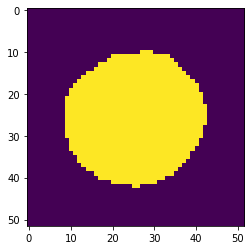

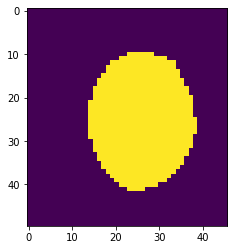

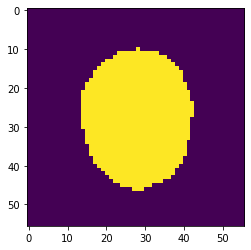

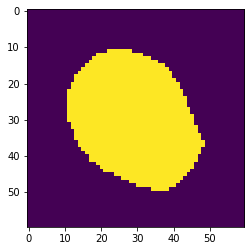

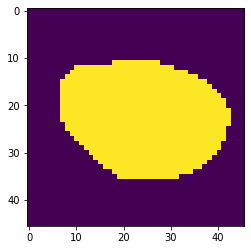

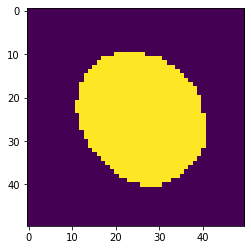

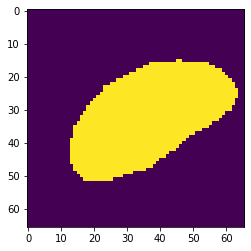

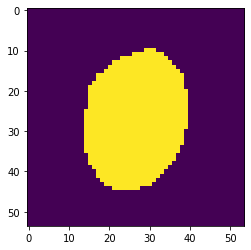

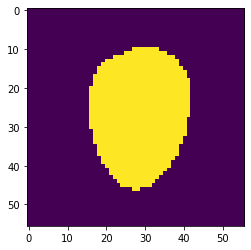

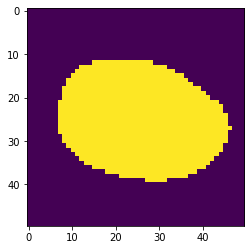

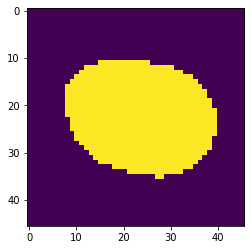

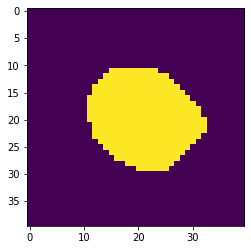

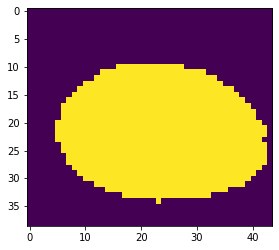

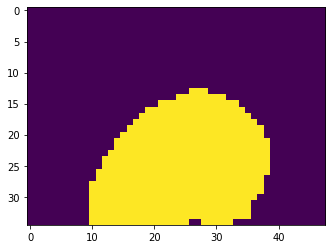

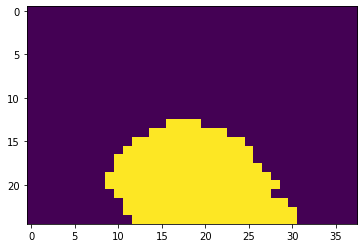

In [15]:
for crop in crops_test:
    plt.imshow(crop)
    plt.show()